In [8]:
if(!require(plyr)) install.packages(c("plyr")) # revalue()
library(plyr)
if(!require(e1071)) install.packages(c("e1071")) #Naive Bayes & svm
library(e1071)
if(!require(caret)) install.packages(c("caret")) #confusion matrix
library(caret)
if(!require(parallel)) install.packages(c("parallel")) #parallel
library(parallel)
if(!require(doParallel)) install.packages(c("doParallel")) #parallel
library(doParallel)
if(!require(randomForest)) install.packages(c("randomForest")) #randomForest
library(randomForest)
if(!require(rpart)) install.packages(c("rpart")) #decision tree
library(rpart)
if(!require(xgboost)) install.packages(c("xgboost")) #xgboost
library(xgboost)
if(!require(Matrix)) install.packages(c("Matrix")) #xgboost
library(Matrix)
if(!require(ROCR)) install.packages(c("ROCR")) #ROC
library(ROCR)

Loading required package: e1071

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice

Loading required package: parallel

Loading required package: doParallel

Loading required package: foreach

Loading required package: iterators

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: rpart

Loading required package: xgboost

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘xgboost’”



The downloaded binary packages are in
	/var/folders/0j/3xzmst7d071c_jy9dktj595m0000gn/T//RtmpFOvUFc/downloaded_packages


Loading required package: Matrix

Loading required package: ROCR



In [9]:
data = data.frame(read.csv('data/BNG_labor.csv'))

# label encoding from eda.
data$cost.of.living.adjustment <- as.factor(data$cost.of.living.adjustment)
data$pension <- as.factor(data$pension)
data$education.allowance <- as.integer(as.character(revalue(data$education.allowance, c('no'=0, 'yes'=1))))
data$vacation <- as.integer(as.character(revalue(data$vacation, c('average'=1, 'below_average'=2, 'generous'=3))))
data$longterm.disability.assistance <- as.integer(as.character(revalue(data$longterm.disability.assistance, c('no'=0, 'yes'=1))))
data$contribution.to.dental.plan <- as.integer(as.character(revalue(data$contribution.to.dental.plan, c('none'=0, 'half'=1, 'full'=2))))
data$bereavement.assistance <- as.integer(as.character(revalue(data$bereavement.assistance, c('no'=0, 'yes'=1))))
data$contribution.to.health.plan <- as.integer(as.character(revalue(data$contribution.to.health.plan, c('none'=0, 'half'=1, 'full'=2))))
data$class <- as.integer(as.character(revalue(data$class, c('bad'=0, 'good'=1))))

#feature engineering
numericVarNames = names(data[,sapply(data, is.numeric)])
data_numeric <- data[, names(data) %in% numericVarNames]
data_factor <- data[, !names(data) %in% numericVarNames]
data_dummy <- as.data.frame(model.matrix(~.-1, data_factor))
data <- cbind(data_numeric, data_dummy)

# remove cost.of.living.adjustmentnone due to correlation test
drop <- c("cost.of.living.adjustmentnone") 
data <- data[,!(names(data) %in% drop)]

#split data int train, test and bias_variance
set.seed(43)
index <- sample(1: nrow(data), nrow(data)*.7, replace=F)
train <- data[index,]
test_bv <-  data[-index,]
set.seed(43)
index_2 <- sample(1: nrow(test_bv), nrow(data)*.2, replace=F)
test <- test_bv[index_2,]
bv_data <- test_bv[-index_2,]

#downsample
subtrain0 <- train[train$class == 0,] #controls
row.name <- rownames(train[train$class == 1,])
set.seed(43)
resample <- sample(row.name, nrow(subtrain0), replace = F)
subtrain1 <- train[resample,]  #cases
train <- rbind(subtrain0,subtrain1)
#shuffle
set.seed(42)
rows <- sample(nrow(train))
train <- train[rows, ]

com_data <- rbind(train, test)

In [10]:
bias.variance <- function (preds, nums){
    mean_pred <- rowMeans(preds)
    df = bv_data
    #Bias
    bias = 0
    for (i in 1:length(df$class)){
        bias = bias + (mean_pred[i]-df$class[i])^2
    }
    bias = bias / length(df$class)
    
    #Variance
    var = 0
    for (i in 1:nums){
        for (j in 1:length(df$class)){
            var = var + (preds[,i][j]-mean_pred[i])^2
        }
        var = var / length(df$class)
    }
    var = var / nums
    
    b_v <- matrix(c(bias, var), ncol=1)
    colnames(b_v) <- c("Value")
    rownames(b_v) <- c("Bias","Variance")
    b_v <- as.data.frame(b_v)
    head(b_v)
}

In [11]:
#base model
set.seed(43)
dt_model <- rpart(class~., data=train, method="class")
# performance on test data set.
dt_test_raw <- predict(dt_model, test[, c(-15)], type="prob")
dt_test_class <-unlist(apply(round(dt_test_raw),1,which.max))-1
dt_test_mtab <- table(test$class, dt_test_class)
dt_test_cmx <- caret::confusionMatrix(dt_test_mtab)
dt_pref <- as.data.frame(rbind(c(dt_test_cmx$overall, dt_test_cmx$byClass)))
dt_test_cmx

Confusion Matrix and Statistics

   dt_test_class
         0      1
  0  63363   7503
  1   9639 119495
                                          
               Accuracy : 0.9143          
                 95% CI : (0.9131, 0.9155)
    No Information Rate : 0.635           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8139          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8680          
            Specificity : 0.9409          
         Pos Pred Value : 0.8941          
         Neg Pred Value : 0.9254          
             Prevalence : 0.3650          
         Detection Rate : 0.3168          
   Detection Prevalence : 0.3543          
      Balanced Accuracy : 0.9044          
                                          
       'Positive' Class : 0               
                                    

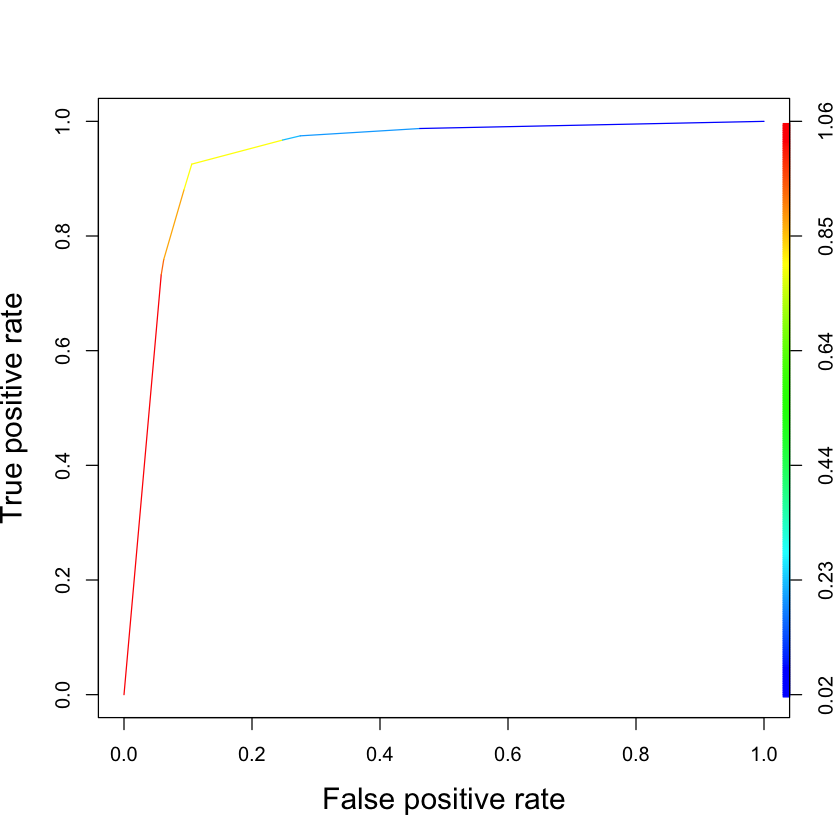

In [12]:
# ROC plot
dt_ROCRpred <- prediction(dt_test_raw[,"1"], test$class)
dt_ROCRperf <- performance(dt_ROCRpred, 'tpr', 'fpr')
plot(dt_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [13]:
# AUC
dt_perf_AUC <- performance(dt_ROCRpred,"auc")
dt_AUC <- dt_perf_AUC@y.values[[1]]
print(paste("AUC: ", dt_AUC))

[1] "AUC:  0.939939971068595"


In [14]:
dt_preformace <- dt_pref[, c(1,9,12,13,14)]
dt_preformace <- cbind(dt_preformace, c(dt_AUC))
colnames(dt_preformace)[6] <- c("AUC")
rownames(dt_preformace) <- c("Value")
print(dt_preformace)

      Accuracy Specificity Precision    Recall        F1     AUC
Value  0.91429   0.9409203 0.8941241 0.8679625 0.8808491 0.93994


In [15]:
#determine bias and variance
cl <- makeCluster(10)
clusterExport(cl, c("rpart", "com_data", "bv_data"), envir=environment())
set.seed(43)
dt_df <- do.call('rbind', parLapply(cl, 1:10, function(i, df=com_data) {
    idx <- sample(1:nrow(df),nrow(df)*.78,replace=F)
    train_data <- df[idx,]
    dt_model <- rpart(class~., data=train_data, method="class")
    dt_test_raw <- predict(dt_model, bv_data[, c(-15)], type="prob")
    dt_test_class <-unlist(apply(round(dt_test_raw),1,which.max))-1
    dt_test_mtab <- table(bv_data$class, dt_test_class)
    dt_test_cmx <- caret::confusionMatrix(dt_test_mtab)
    dt_pref <- as.data.frame(rbind(c(dt_test_cmx$overall, dt_test_cmx$byClass)))
    list(prob=dt_test_raw[,"1"], perf=dt_pref)
}
))
stopCluster(cl)

In [16]:
dt_df <- as.data.frame(dt_df)
dt.perf <- dt_df$perf
dt.perf<-as.data.frame(do.call('rbind',lapply(dt.perf,FUN=function(perf) perf)))
dt.perf.var<-apply(dt.perf[dt.perf$AccuracyPValue<0.01,-c(6:7)],2,sd)
print(dt.perf.var)
dt.perf.mean<-apply(dt.perf[dt.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
print(dt.perf.mean)
dt.prob <- as.data.frame(dt_df$prob)
dt_b_v <- bias.variance(dt.prob, 10)
print(dt_b_v)

            Accuracy                Kappa        AccuracyLower 
         0.002958968          0.007368740          0.002985639 
       AccuracyUpper         AccuracyNull          Sensitivity 
         0.002932123          0.007599423          0.003773362 
         Specificity       Pos Pred Value       Neg Pred Value 
         0.007455183          0.014887537          0.003595286 
           Precision               Recall                   F1 
         0.014887537          0.003773362          0.005460101 
          Prevalence       Detection Rate Detection Prevalence 
         0.007599423          0.005279121          0.000000000 
   Balanced Accuracy 
         0.001841437 
            Accuracy                Kappa        AccuracyLower 
           0.9129830            0.8104893            0.9112193 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9147227            0.6401510            0.8718707 
         Specificity       Pos Pred Value       Neg Pred Val

### XGBoost

In [17]:
train_mx<-sparse.model.matrix(class~.-1,data=train)
test_mx<-sparse.model.matrix(class~.-1,data=test)

xgb_model<-xgboost(data=train_mx, 
                               label=train$class, 
                               max_depth = 4, 
                               eta = 1, 
                               nrounds = 3, 
                               nthread = 2, 
                              objective = "multi:softprob",# to get probs
                              num_class=2)

[22:02:12] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-mlogloss:0.326262 
[2]	train-mlogloss:0.247122 
[3]	train-mlogloss:0.203093 


In [18]:
#performance on the training data set
xgb_pred <- predict(xgb_model, train_mx)
xgb_pred_df<-data.frame(actual=train$class, prob.1=xgb_pred[seq(0,length(xgb_pred),by=2)], prob.0=xgb_pred[seq(1,length(xgb_pred),by=2)])
xgb_pred_class<-ifelse(xgb_pred_df$prob.0>xgb_pred_df$prob.1,0,1)
xgb_tbl<-table(train$class,xgb_pred_class)
xgb_cfm<-caret::confusionMatrix(xgb_tbl)
print(xgb_cfm)

Confusion Matrix and Statistics

   xgb_pred_class
         0      1
  0 223810  22864
  1  14069 232605
                                          
               Accuracy : 0.9251          
                 95% CI : (0.9244, 0.9259)
    No Information Rate : 0.5178          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8503          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9409          
            Specificity : 0.9105          
         Pos Pred Value : 0.9073          
         Neg Pred Value : 0.9430          
             Prevalence : 0.4822          
         Detection Rate : 0.4537          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.9257          
                                          
       'Positive' Class : 0               
                                   

In [19]:
#performance on the test data set
xgb_pred <- predict(xgb_model, test_mx)
xgb_pred_df<-data.frame(actual=test$class, prob.1=xgb_pred[seq(0,length(xgb_pred),by=2)], prob.0=xgb_pred[seq(1,length(xgb_pred),by=2)])
xgb_pred_class<-ifelse(xgb_pred_df$prob.0>xgb_pred_df$prob.1,0,1)
xgb_tbl<-table(test$class,xgb_pred_class)
xgb_cfm<-caret::confusionMatrix(xgb_tbl)
print(xgb_cfm)

Confusion Matrix and Statistics

   xgb_pred_class
         0      1
  0  64171   6695
  1   7210 121924
                                          
               Accuracy : 0.9305          
                 95% CI : (0.9294, 0.9316)
    No Information Rate : 0.6431          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8483          
                                          
 Mcnemar's Test P-Value : 1.307e-05       
                                          
            Sensitivity : 0.8990          
            Specificity : 0.9479          
         Pos Pred Value : 0.9055          
         Neg Pred Value : 0.9442          
             Prevalence : 0.3569          
         Detection Rate : 0.3209          
   Detection Prevalence : 0.3543          
      Balanced Accuracy : 0.9235          
                                          
       'Positive' Class : 0               
                                   

[1] "AUC:  0.974033237478163"


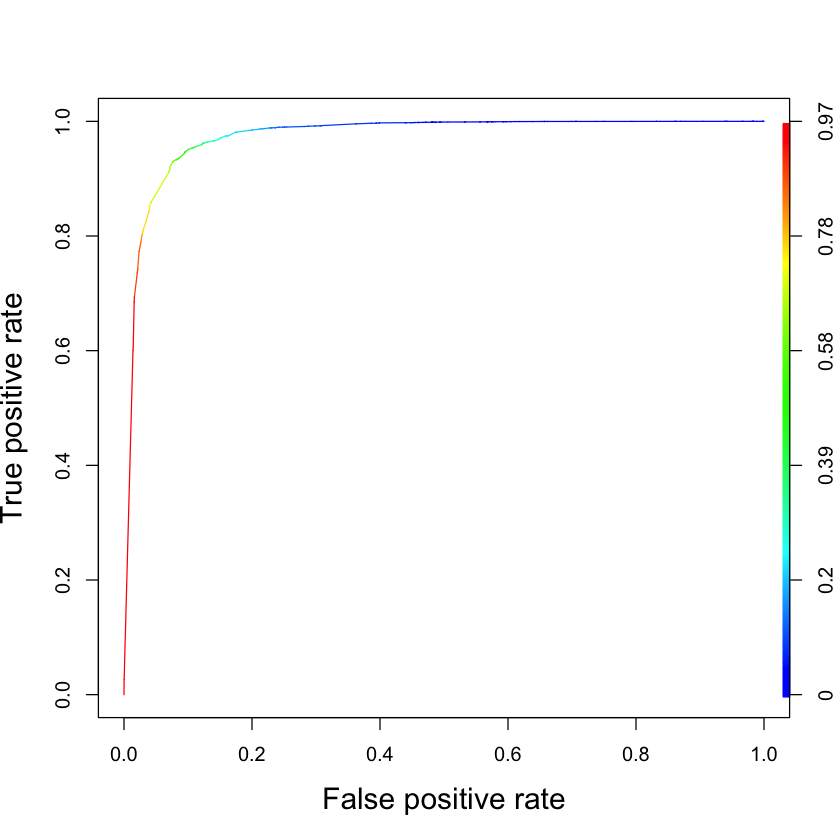

In [20]:
# ROC plot
xgb_ROCRpred <- prediction(xgb_pred[seq(0,length(xgb_pred),by=2)], test$class)
xgb_ROCRperf <- performance(xgb_ROCRpred, 'tpr', 'fpr')
plot(xgb_ROCRperf, colorize = TRUE, cex.lab=1.5)
# AUC
xgb_perf_AUC <- performance(xgb_ROCRpred,"auc")
xgb_AUC <- xgb_perf_AUC@y.values[[1]]
print(paste("AUC: ", xgb_AUC))

In [21]:
#determine bias and variance
start_time <- Sys.time()
cl <- makeCluster(10)
clusterExport(cl, c("xgboost", "com_data", "bv_data", "sparse.model.matrix"), envir=environment())
set.seed(43)
xg_df <- do.call('rbind', parLapply(cl, 1:10, function(i, df=com_data) {
    idx <- sample(1:nrow(df),nrow(df)*.78,replace=F)
    train_data <- df[idx,]
    train_mx <- sparse.model.matrix(class~.-1,data=train_data)
    bv_mx <- sparse.model.matrix(class~.-1,data=bv_data)
    xgb_model <- xgboost(data=train_mx, 
                               label=train_data$class, 
                               max_depth = 4, 
                               eta = 1, 
                               nrounds = 3, 
                               nthread = 2, 
                              objective = "multi:softprob",# to get probs
                              num_class=2)
    xgb_pred<-predict(xgb_model, bv_mx)
    xgb_pred_df<-data.frame(actual=bv_data$class, prob.1=xgb_pred[seq(0,length(xgb_pred),by=2)], prob.0=xgb_pred[seq(1,length(xgb_pred),by=2)])
    xgb_pred_class<-ifelse(xgb_pred_df$prob.0>xgb_pred_df$prob.1,0,1)
    mtab<-table(bv_data$class, xgb_pred_class)
    cmx<-caret::confusionMatrix(mtab)
    performance <- as.data.frame(rbind(c(cmx$overall, cmx$byClass))) 
    list(prob=xgb_pred_df$prob.1, perf=performance)
}
))
stopCluster(cl)
end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='mins')
print(difference)

Time difference of 0.8119834 mins


In [22]:
xg_df <- as.data.frame(xg_df)
xg.perf <- xg_df$perf
xg.perf<-as.data.frame(do.call('rbind',lapply(xg.perf,FUN=function(perf) perf)))
xg.perf.var<-apply(xg.perf[xg.perf$AccuracyPValue<0.01,-c(6:7)],2,sd)
print(xg.perf.var)
xg.perf.mean<-apply(xg.perf[xg.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
print(xg.perf.mean)
xg.prob <- as.data.frame(xg_df$prob)
xg_b_v <- bias.variance(xg.prob, 10)
print(xg_b_v)

            Accuracy                Kappa        AccuracyLower 
        0.0017242016         0.0027136062         0.0017420049 
       AccuracyUpper         AccuracyNull          Sensitivity 
        0.0017062969         0.0107151971         0.0144042340 
         Specificity       Pos Pred Value       Neg Pred Value 
        0.0060915606         0.0126854523         0.0096338719 
           Precision               Recall                   F1 
        0.0126854523         0.0144042340         0.0009310058 
          Prevalence       Detection Rate Detection Prevalence 
        0.0107151971         0.0044982614         0.0000000000 
   Balanced Accuracy 
        0.0041584908 
            Accuracy                Kappa        AccuracyLower 
           0.9290160            0.8450939            0.9274070 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9306000            0.6437760            0.8984765 
         Specificity       Pos Pred Value       Neg Pred Val

In [23]:
#compare xgboost and base model performance
xgb_performance <- as.data.frame(rbind(c(xgb_cfm$overall, xgb_cfm$byClass)))
xgb_performance <- xgb_performance[, c(1,9,12,13,14)]
xgb_performance <- cbind(xgb_performance, c(xgb_AUC))
colnames(xgb_performance)[6] <- c("AUC")
compare_perf <- rbind(dt_preformace, xgb_performance)
rownames(compare_perf) <- c("Tree", "XGBoost")
print(compare_perf)

        Accuracy Specificity Precision    Recall        F1       AUC
Tree    0.914290   0.9409203 0.8941241 0.8679625 0.8808491 0.9399400
XGBoost 0.930475   0.9479470 0.9055259 0.8989927 0.9022475 0.9740332


In [24]:
compare_bv <- cbind(dt_b_v, xg_b_v)
colnames(compare_bv) <- c("Tree", "XGBoost")
print(compare_bv)

               Tree    XGBoost
Bias     0.07248888 0.05303523
Variance 0.02560218 0.02863625


### Cross Validation

In [67]:
train$class <- as.factor(train$class)
com_data$class <- as.factor(com_data$class)

#### 10 folds

In [26]:
N<-nrow(train)
NF=10
folds_10 <-split(1:N,cut(1:N, quantile(1:N, probs = seq(0, 1, by =1/NF))))

In [27]:
set.seed(43)
ridx<-sample(1:nrow(train),nrow(train),replace=FALSE) # randomize the data

start_time <- Sys.time()
cl <- makeCluster(10)
clusterExport(cl, c("rpart", "train", "ridx"), envir=environment())

cv_df<-do.call('rbind',parLapply(cl, folds_10, function(idx,data=train[ridx,]) {
   m<-rpart(class~., data=data[-idx,], method="class") # keep one fold for validation
   p<-predict(m,data[idx,-c(15)],type='prob') # predict for that test fold
   pc<-unlist(apply(round(p),1,which.max))-1
   pred_tbl<-table(data[idx,c(15)], pc) #table(actual,predicted)
   pred_cfm<-caret::confusionMatrix(pred_tbl)
   list(fold=idx,m=m,cfm=pred_cfm) # store the fold, model, cfm 
  }
)) # lapply repeats over all folds

stopCluster(cl)
end_time <- Sys.time()
cv_difference <- difftime(end_time, start_time, units='mins')
print(cv_difference)

Time difference of 1.910017 mins


In [28]:
#cv_nb performance.
cv_df<-as.data.frame(cv_df)
cv.perf<-as.data.frame(do.call('rbind',lapply(cv_df$cfm,FUN=function(cfm)c(cfm$overall,cfm$byClass))))                                    
cv.perf.mean<-apply(cv.perf[cv.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
print(cv.perf.mean)

            Accuracy                Kappa        AccuracyLower 
           0.9099376            0.8198734            0.9073774 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9124496            0.5139689            0.9217221 
         Specificity       Pos Pred Value       Neg Pred Value 
           0.8987963            0.8959654            0.9239081 
           Precision               Recall                   F1 
           0.8959654            0.9217221            0.9086600 
          Prevalence       Detection Rate Detection Prevalence 
           0.4860311            0.4479849            0.5000010 
   Balanced Accuracy 
           0.9102592 


In [29]:
#How will the Cross-Validated model handle never seen-before data?
cl <- makeCluster(10)
clusterExport(cl, c("rpart", "test"), envir=environment())
tstcv_preds<-parLapply(cl, cv_df$m, function(M,D=test[,-c(15)]) predict(M,D,type='prob'))
tstcv_cfm<-parLapply(cl, tstcv_preds, function(P, A=test[[15]])
{pred_class<-unlist(apply(round(P),1,which.max))-1
  pred_tbl<-table(pred_class, A)
  pred_cfm<-caret::confusionMatrix(pred_tbl)
  pred_cfm
})
tstcv_pred <- parLapply(cl, tstcv_preds, function(P) {P[,"1"]})
stopCluster(cl)   

tstcv.perf<-as.data.frame(do.call('rbind',lapply(tstcv_cfm,FUN=function(cfm)c(cfm$overall,cfm$byClass))))
cv.tst.perf<-apply(tstcv.perf[tstcv.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
print(cv.tst.perf)                                           

            Accuracy                Kappa        AccuracyLower 
           0.9143040            0.8139758            0.9130687 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9155272            0.6456700            0.8941396 
         Specificity       Pos Pred Value       Neg Pred Value 
           0.9253698            0.8679849            0.9409293 
           Precision               Recall                   F1 
           0.8679849            0.8941396            0.8808681 
          Prevalence       Detection Rate Detection Prevalence 
           0.3543300            0.3168205            0.3650070 
   Balanced Accuracy 
           0.9097547 


[1] "AUC:  0.940157102845753"


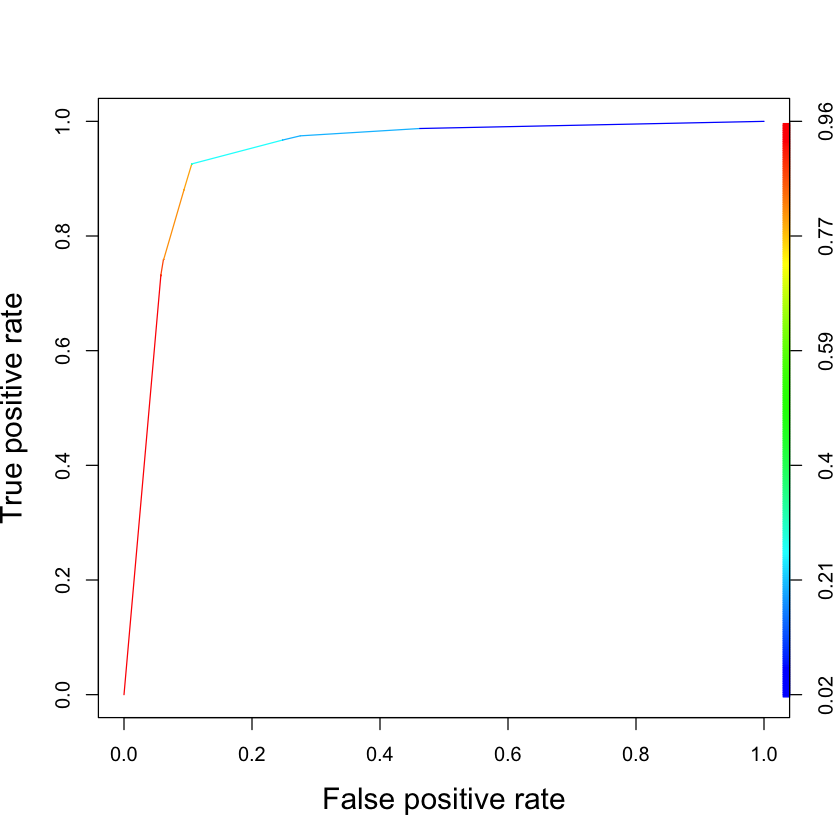

In [30]:
tstcv_pred<-as.data.frame(tstcv_pred)
tstcv_prob<-rowMeans(tstcv_pred)

# ROC plot
cv_ROCRpred <- prediction(tstcv_prob, test$class)
cv_ROCRperf <- performance(cv_ROCRpred, 'tpr', 'fpr')
plot(cv_ROCRperf, colorize = TRUE, cex.lab=1.5)
# AUC
cv_perf_AUC <- performance(cv_ROCRpred,"auc")
cv_AUC <- cv_perf_AUC@y.values[[1]]
print(paste("AUC: ", cv_AUC))

In [32]:
start_time <- Sys.time()
cl <- makeCluster(10)
clusterExport(cl, c("rpart", "com_data", "bv_data"), envir=environment())
set.seed(43)
cvs_df <- do.call('rbind', parLapply(cl, 1:10, function(i, df=com_data) {
    idx <- sample(1:nrow(df),nrow(df)*.78,replace=F)
    train_data <- df[idx,]
    N<-nrow(train_data)
    NF<-10
    folds_10 <-split(1:N,cut(1:N, quantile(1:N, probs = seq(0, 1, by =1/NF))))
    ridx<-sample(1:nrow(train_data),nrow(train_data),replace=FALSE) # randomize the data
    cv_df<-do.call('rbind',lapply(folds_10, FUN=function(idx,data=train_data[ridx,]) {
        m<-rpart(class~., data=data[-idx,], method="class") # keep one fold for validation
        p<-predict(m,bv_data[,-c(15)],type='prob') # predict for the VAR data set
        pc<-unlist(apply(round(p),1,which.max))-1
        pred_tbl<-table(bv_data[,c(15)], pc) #table(actual,predicted)
        pred_cfm<-caret::confusionMatrix(pred_tbl)
        list(fold=idx,m=m,cfm=pred_cfm, prob=p[,"1"]) # store the fold, model, cfm, prediction
    })) # lapply repeats over all folds
    cv_df<-as.data.frame(cv_df)
    cv.perf<-as.data.frame(do.call('rbind',lapply(cv_df$cfm,FUN=function(cfm)c(cfm$overall,cfm$byClass))))
    cv.perf.mean<-apply(cv.perf[cv.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
    probs<-as.data.frame(cv_df$prob)
    mean_prob <- rowMeans(probs)
    list(perf=cv.perf.mean, prob=mean_prob)
}))
stopCluster(cl)
end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='mins')
print(difference)

cvs_df <- as.data.frame(cvs_df)
cvs.prob <- as.data.frame(cvs_df$prob)
cv_b_v <- bias.variance(cvs.prob, 10)
print(cv_b_v)

Time difference of 17.56789 mins
              Value
Bias     0.07359504
Variance 0.02452579


In [55]:
cvs.perf <- as.data.frame(cvs_df$perf)
cv.perf.var<-apply(cvs.perf,1,sd)
cv.perf.var <- as.data.frame(t(cv.perf.var))
print(cv.perf.var)

     Accuracy     Kappa AccuracyLower AccuracyUpper AccuracyNull Sensitivity
1 0.001884607 0.0046936   0.001901596   0.001867509  0.004844274 0.002408893
  Specificity Pos Pred Value Neg Pred Value   Precision      Recall          F1
1 0.004750894    0.009487473    0.002293536 0.009487473 0.002408893 0.003478132
   Prevalence Detection Rate Detection Prevalence Balanced Accuracy
1 0.004844274    0.003364258                    0        0.00117232


In [60]:
cv.perf.mean<-apply(cvs.perf,1,mean)
cv.perf.mean <- as.data.frame(t(cv.perf.mean))
print(cv.perf.mean)

   Accuracy     Kappa AccuracyLower AccuracyUpper AccuracyNull Sensitivity
1 0.9119592 0.8079339     0.9101863     0.9137082    0.6428282    0.873226
  Specificity Pos Pred Value Neg Pred Value Precision   Recall        F1
1   0.9336016      0.8794853      0.9298012 0.8794853 0.873226 0.8762543
  Prevalence Detection Rate Detection Prevalence Balanced Accuracy
1  0.3571718      0.3118655               0.3546         0.9034138


In [59]:
#compare cv and base model performance
cv.tst.perf<-as.data.frame(t(cv.tst.perf))
cv_performance <- cv.tst.perf[, c(1,7,10,11,12)]
cv_performance <- cbind(cv_performance, c(cv_AUC))
colnames(cv_performance)[6] <- c("AUC")
compare_perf <- rbind(dt_preformace, cv_performance)
rownames(compare_perf) <- c("Tree", "CV")
print(compare_perf)

     Accuracy Specificity Precision    Recall        F1       AUC
Tree 0.914290   0.9409203 0.8941241 0.8679625 0.8808491 0.9399400
CV   0.914304   0.9253698 0.8679849 0.8941396 0.8808681 0.9401571


In [53]:
compare_bv <- cbind(dt_b_v, cv_b_v)
colnames(compare_bv) <- c("Tree", "CV")
print(compare_bv)

               Tree         CV
Bias     0.07248888 0.07359504
Variance 0.02560218 0.02452579


### Random Forest

In [68]:
## Parallel Computing
## random forest should use factor class
start_time <- Sys.time()
cores <- 10
cl <- makeCluster(cores)
registerDoParallel(cores)
rf50_model<-randomForest(class~.,data=train, ntree=50)
stopCluster(cl)
end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='mins')
print(difference)

In [62]:
#performance on the training data set
rf50_pred<-predict(rf50_model, train[,-c(15)])
rf50_mtab<-table(train$class, rf50_pred)
rf50_cmx<-caret::confusionMatrix(rf50_mtab)
print(rf50_cmx)

Confusion Matrix and Statistics

   rf50_pred
         0      1
  0 244116   2558
  1   1194 245480
                                          
               Accuracy : 0.9924          
                 95% CI : (0.9921, 0.9926)
    No Information Rate : 0.5028          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9848          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9951          
            Specificity : 0.9897          
         Pos Pred Value : 0.9896          
         Neg Pred Value : 0.9952          
             Prevalence : 0.4972          
         Detection Rate : 0.4948          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.9924          
                                          
       'Positive' Class : 0               
                                        

In [63]:
#performance on the test data set
rf50_pred <- predict(rf50_model, test[,-c(15)], type="prob")
rf50_class <- unlist(apply(round(rf50_pred),1,which.max))-1
rf50_mtab<-table(test$class, rf50_class)
rf50_cmx<-caret::confusionMatrix(rf50_mtab)
print(rf50_cmx)

Confusion Matrix and Statistics

   rf50_class
         0      1
  0  67957   2909
  1   4834 124300
                                          
               Accuracy : 0.9613          
                 95% CI : (0.9604, 0.9621)
    No Information Rate : 0.636           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9159          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9336          
            Specificity : 0.9771          
         Pos Pred Value : 0.9590          
         Neg Pred Value : 0.9626          
             Prevalence : 0.3640          
         Detection Rate : 0.3398          
   Detection Prevalence : 0.3543          
      Balanced Accuracy : 0.9554          
                                          
       'Positive' Class : 0               
                                       

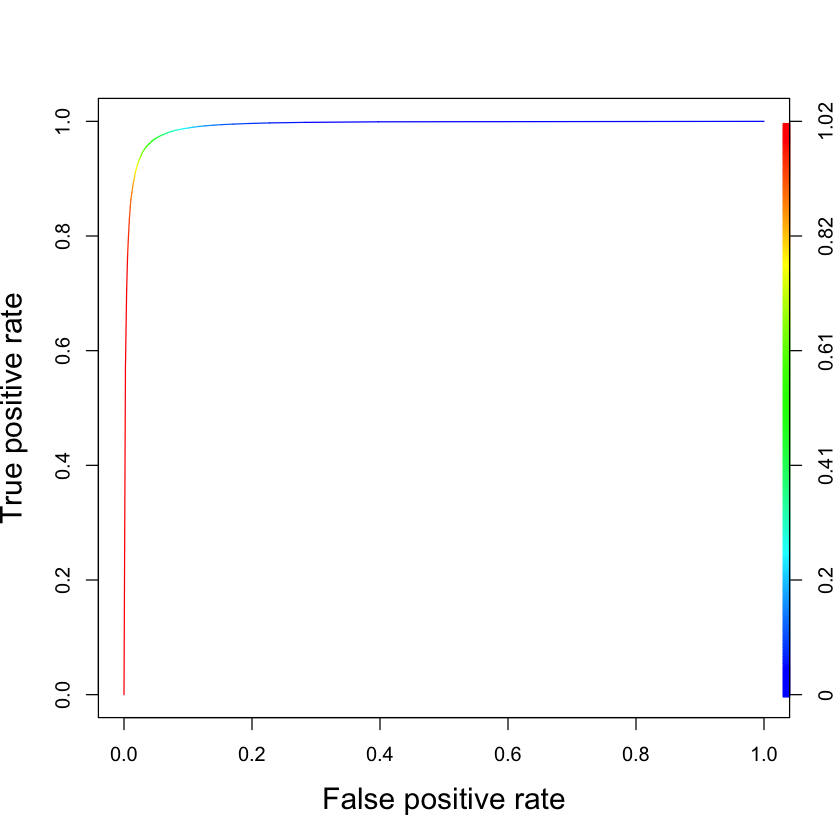

In [64]:
# ROC plot
rf50_ROCRpred <- prediction(rf50_pred[,"1"], test$class)
rf50_ROCRperf <- performance(rf50_ROCRpred, 'tpr', 'fpr')
plot(rf50_ROCRperf, colorize = TRUE, cex.lab=1.5)

In [65]:
# AUC
rf50_perf_AUC <- performance(rf50_ROCRpred,"auc")
rf50_AUC <- rf50_perf_AUC@y.values[[1]]
print(paste("AUC: ", rf50_AUC))

[1] "AUC:  0.991784058049318"


In [66]:
#determine bias and variance
start_time <- Sys.time()
cl <- makeCluster(10)
clusterExport(cl, c("randomForest", "com_data", "bv_data"), envir=environment())
set.seed(43)
rf50_df <- do.call('rbind', parLapply(cl, 1:10, function(i, df=com_data) {
    idx <- sample(1:nrow(df),nrow(df)*.78,replace=F)
    train_data <- df[idx,]
    m <- randomForest(class~.,data=train_data, ntree=50)
    pred<-predict(m, bv_data[,-c(15)],  type="prob")
    class <- unlist(apply(round(pred),1,which.max))-1
    mtab<-table(bv_data$class, class)
    cmx<-caret::confusionMatrix(mtab)
    performance <- as.data.frame(rbind(c(cmx$overall, cmx$byClass))) 
    list(m=m, prob=pred[,c("1")], perf=performance)
}
))
stopCluster(cl)
end_time <- Sys.time()
difference <- difftime(end_time, start_time, units='mins')
print(difference)

In [ ]:
rf50_df <- as.data.frame(rf50_df)
rf50.perf <- rf50_df$perf
rf50.perf<-as.data.frame(do.call('rbind',lapply(rf50.perf,FUN=function(perf) perf)))
rf50.perf.var<-apply(rf50.perf[rf50.perf$AccuracyPValue<0.01,-c(6:7)],2,sd)
print(rf50.perf.var)

In [ ]:
rf50.perf.mean<-apply(rf50.perf[rf50.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
print(rf50.perf.mean)

In [ ]:
rf50.prob <- as.data.frame(rf50_df$prob)
rf50_b_v <- bias.variance(rf50.prob, 10)
print(rf50_b_v)

In [ ]:
#compare rf50 and base model performance
rf50_performance <- as.data.frame(rbind(c(rf50_cmx$overall, rf50_cmx$byClass)))
rf50_performance <- rf50_performance[, c(1,9,12,13,14)]
rf50_performance <- cbind(rf50_performance, c(rf50_AUC))
colnames(rf50_performance)[6] <- c("AUC")
compare_perf <- rbind(dt_preformace, rf50_performance)
rownames(compare_perf) <- c("Tree", "Random forest")
print(compare_perf)

In [ ]:
compare_bv <- cbind(dt_b_v, rf50_b_v)
colnames(compare_bv) <- c("Tree", "Random Forest")
print(compare_bv)

In [ ]:
all_perf <- rbind(dt_preformace, xgb_performance, rf50_performance, cv_performance)
rownames(all_perf) <- c("Tree", "XGBoost", "RF", "CV")
all_perf <- as.data.frame(t(all_perf))
print(all_perf)

In [ ]:
all_bv <- cbind(dt_b_v, xg_b_v, rf50_b_v, cv_b_v)
colnames(all_bv) <- c("Tree", "XGBoost", "RF", "CV")
print(all_bv)